In [1]:
# Importing the necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import random
from skimage.feature import corner_harris, corner_peaks

In [2]:
# Loading the images
img_ = cv2.imread("rightImage.png")
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
img = cv2.imread("leftImage.png")
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [3]:
# Finding harris peak corners' coordinates
corner_peak_cords1 = corner_peaks(corner_harris(img1), min_distance=1, threshold_rel=0)
corner_peak_cords2 = corner_peaks(corner_harris(img2), min_distance=1, threshold_rel=0)

For the left image, the k value that returns the most number of corners is :0.21428571428571427
For the right image, the k value that returns the most number of corners is :0.21428571428571427


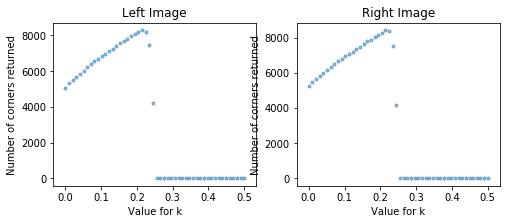

In [4]:
# Correlation between k in harris corners and number of corners returned
k_range = np.linspace(0, 0.5, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
corner_no1 = []
corner_no2 = []
for i in k_range:
        c1 = corner_peaks(corner_harris(img1, k=i), min_distance=1, threshold_rel=0)
        a = len(c1)
        corner_no1.append(a)
for i in k_range:
        c2 = corner_peaks(corner_harris(img2, k=i), min_distance=1, threshold_rel=0)
        b = len(c2)
        corner_no2.append(b)

colors = (0,0,250)
area = np.pi*3

f, axarr = plt.subplots(1,2, figsize=(8,3)) 
axarr[0].scatter(k_range, corner_no2, s=area, alpha=0.5)
axarr[1].scatter(k_range, corner_no1, s=area, alpha=0.5)
#axarr[0].title('Sensitivity analysis for k (alpha)')

axarr[0].set_xlabel('Value for k')
axarr[0].set_ylabel('Number of corners returned')
axarr[1].set_xlabel('Value for k')
axarr[1].set_ylabel('Number of corners returned')

axarr[0].set_title('Left Image')
axarr[1].set_title('Right Image')

print("For the left image, the k value that returns the most number of corners is :" + str(k_range[corner_no2.index(max(corner_no2))]))
print("For the right image, the k value that returns the most number of corners is :" + str(k_range[corner_no1.index(max(corner_no1))]))
plt.show()

In [5]:
# Creating the keypoints from the peak corners' coordinates
keypoints1 = [cv2.KeyPoint(x[0], x[1], 1) for x in corner_peak_cords1]
keypoints2 = [cv2.KeyPoint(x[0], x[1], 1) for x in corner_peak_cords2]

In [6]:
# Creating the descriptors from the keypoints
sift = cv2.xfeatures2d.SIFT_create()
descriptors1 = [sift.compute(img1,[kp])[1] for kp in keypoints1]
descriptors2 = [sift.compute(img2,[kp])[1] for kp in keypoints2]

In [7]:
# Transforming descriptors to arrays fo further computations
l1 = []
for i in range(len(descriptors1)):
    a= np.array(descriptors1[i][0])
    l1.append(a)
d1 = np.array(l1)

l2 = []
for i in range(len(descriptors2)):
    a= np.array(descriptors2[i][0])
    l2.append(a)
d2 = np.array(l2)

In [8]:
# Normalizing descriptors
d1 = (d1 - np.mean(d1)) / np.std(d1)
d2 = (d2 - np.mean(d2)) / np.std(d2)

In [9]:
# Implementation of matcher that calculates the euclidean distance between descriptors and matches them if the ratio for nearest neighbor over second nearest neighbor is below threshold
# The code uses this function overall, but it is very slow so I also included brute_force_matcher function that does the same calculation from imported libraries
def matches(d1, d2, t=0.8):
    m1 = []
    m2 = []

    for i in range(len(d1)):
        l = []
        for j in range(len(d2)):
            a = np.linalg.norm(d1[i]-d2[j])
            l.append(a)

        ind_l = np.argsort(l)
        if l[ind_l[0]]/l[ind_l[1]] < t:
            m1.append(corner_peak_cords1[i])
            m2.append(corner_peak_cords2[ind_l[0]])

    m1 = np.array(m1)
    m2 = np.array(m2)    
    
    return m1, m2

In [10]:
# Calling the matches function to retrieve indices of matches from both images
m1, m2 = matches(d1, d2, t=0.8)

In [11]:
# Another matching function, uses BFMatcher since it is a lot faster than my implementation which is matches()
# Will be used for sensitivity analysis since it works faster
def brute_force_matcher(d1, d2, t=0.8):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)
    good = []
    for m in matches:
        if m[0].distance < t*m[1].distance:
            good.append(m)
    matches = np.asarray(good)
    return matches

Text(0.5, 1.0, 'Sensitivity analysis for matches')

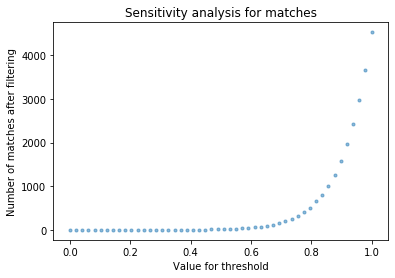

In [12]:
# Correlation Between threshold value and number of matches
k_range = np.linspace(0, 1, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
no_matches = []
for i in k_range:
    matches = brute_force_matcher(d1, d2, t=i)
    no_matches.append(len(matches))
area = np.pi*3
plt.scatter(k_range, no_matches, s=area, alpha=0.5)
plt.xlabel("Value for threshold")
plt.ylabel("Number of matches after filtering")
plt.title("Sensitivity analysis for matches")

In [13]:
# Ransac Function, takes mathes' coordinates from m1 and m2, I is the number of iterations and err is the error value for calculating inliers
def ransac(m1, m2, I, err):
    T=0
    for j in range(I):
        a, b, c = random.sample(range(len(m1)), 3)
        pt1 = np.float32([m1[a],m1[b], m1[c]])
        pt2 = np.float32([m2[a],m2[b], m2[c]])
        d = cv2.getAffineTransform(pt1,pt2)

        outliers = []
        inliers = []
        for i in range(len(m1)):
            error = np.sqrt((d[0][0]*m1[i][0] + d[0][1]*m1[i][1] + d[0][2] - m2[i][0])**2 + (d[1][0]*m1[i][0] + d[1][1]*m1[i][1] + d[1][2] - m2[i][1])**2)
            if error<err:
                inliers.append(i)
            else:
                outliers.append(i)
        inlier_no = len(inliers)
        if inlier_no > T:
            T = inlier_no
            best_model = d
            inlier_ind = inliers
        else:
            continue
            
    return best_model, inlier_ind

In [14]:
# Implementation of ransac function, returns the best affine transform matrix and the indices of matches that are inliers
M, inn = ransac(m1, m2, 10000, 2)

In [15]:
# Average residual for inliers
e = 0
for i in inn:
    error = np.sqrt((M[0][0]*m1[i][0] + M[0][1]*m1[i][1] + M[0][2] - m2[i][0])**2 + (M[1][0]*m1[i][0] + M[1][1]*m1[i][1] + M[1][2] - m2[i][1])**2)
    e = e + error
avg_error = e/len(m1)
print(avg_error)

0.025075287809638927


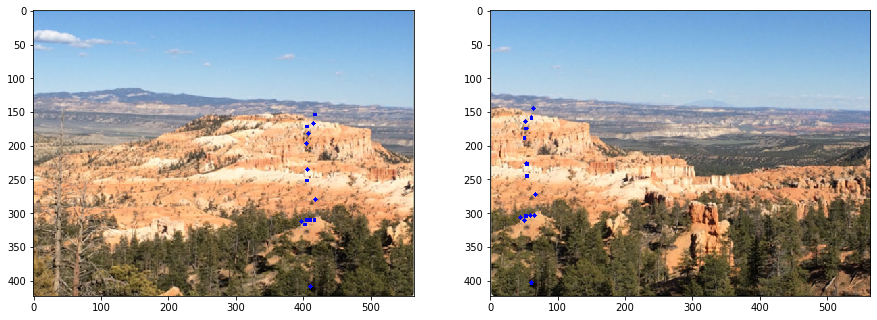

In [16]:
# Displaying the inliers from the acquired affine transform in both images
img_RGB = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_copy = img_RGB.copy()
imgcopy = imgRGB.copy()
for i in m1[inn]: 
    x, y = i.ravel() 
    cv2.circle(img_copy, (x, y), 3, (0, 0, 255), -1) 
for i in m2[inn]: 
    x, y = i.ravel() 
    cv2.circle(imgcopy, (x, y), 3, (0, 0, 255), -1) 
f, axarr = plt.subplots(1,2, figsize=(15,15)) 
axarr[0].imshow(imgcopy)
axarr[1].imshow(img_copy)

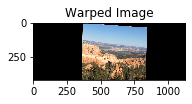

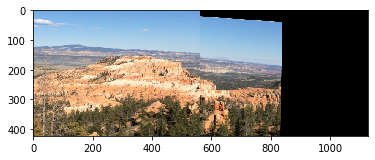

In [17]:
# Warping of the two images using the affine transformation M acquired from ransac function
dst = cv2.warpAffine(img_RGB,M,(imgRGB.shape[1] + img_RGB.shape[1], imgRGB.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title("Warped Image")
plt.show()
plt.figure()
dst[0:imgRGB.shape[0], 0:imgRGB.shape[1]] = imgRGB
plt.imshow(dst)
plt.show()

In [18]:
# Saving the stitched image
cv2.imwrite('Stitched_Image.png', dst)


True

In [19]:
# Accuracy function, measures the euclidean distance between keypoints after transformation and their matches
def accuracy(m1, m2, M):
    e = 0
    for i in range(len(m1)):
        error = np.sqrt((M[0][0]*m1[i][0] + M[0][1]*m1[i][1] + M[0][2] - m2[i][0])**2 + (M[1][0]*m1[i][0] + M[1][1]*m1[i][1] + M[1][2] - m2[i][1])**2)
        e = e + error
    avg_error = e/len(m1)
    return(avg_error)   

In [20]:
# Accuracy of this transformation
avg_error = accuracy(m1,m2, M)
print(avg_error)

327.4075060699812


Text(0.5, 1.0, 'Sensitivity analysis for threshold')

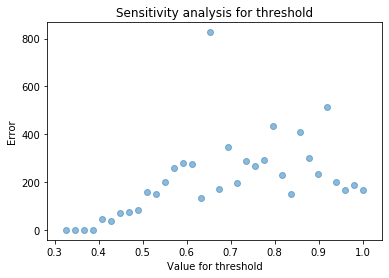

In [28]:
# Sensitivity Analysis of Accuracy(Error) with respect to threshold for matches
matches_i = []
for i in k_range:
    matches = brute_force_matcher(d1, d2, t=i)
    matches_i.append(matches)
M_list = []
src_list = []
dst_list = []
for i in matches_i:
    if len(i)<3:
        M_list.append([])
        src_list.append([])
        dst_list.append([])
    else:
        src = np.float32([ keypoints1[m.queryIdx].pt for m in i[:,0] ]).reshape(-1,1,2)
        dst = np.float32([ keypoints2[m.trainIdx].pt for m in i[:,0] ]).reshape(-1,1,2)
        src = src.reshape(len(src), 2)
        dst = dst.reshape(len(dst),2)
        src_list.append(src)
        dst_list.append(dst)
        
        M_temp, inn_temp = ransac(src, dst, 100, 2)
        M_list.append(M_temp)

acc_list = []
for i in range(len(M_list)):
    m1_temp = src_list[i]
    m2_temp = dst_list[i]
    M_temp = M_list[i]
    if len(M_temp)==0:
        acc_list.append(np.nan)
    else:
        acc = accuracy(m1_temp, m2_temp, M_temp)
        acc_list.append(acc)

plt.scatter(k_range, acc_list, alpha=0.5)
plt.xlabel("Value for threshold")
plt.ylabel("Error")
plt.title("Sensitivity analysis for threshold")